# Airbnb Pricing and Occupancy Trends in New York City
### Introduction
Short-term rental platforms like Airbnb have revolutionized the hospitality industry, offering unique accommodations for travelers and income opportunities for hosts. In this project, we analyze Airbnb pricing and occupancy trends in New York City—a highly active market with diverse price points—to provide actionable insights for hosts, travelers, and city planners. Using data from Inside Airbnb, we will explore price variations, seasonal trends, amenity impacts, property type distributions, and occupancy patterns.

### 1. Data Preparation & Cleaning
#### Loading the Data
We start by loading the Airbnb listings and calendar datasets for New York City, sourced from Inside Airbnb. The listings data contains property details, while the calendar data provides availability information.



In [5]:
import pandas as pd

# Define data types for calendar.csv with nullable integers
calendar_dtypes = {
    'listing_id': 'Int64',  # Also use Int64 here in case of missing listing IDs
    'date': str,
    'available': str,
    'price': str,
    'adjusted_price': str,
    'minimum_nights': 'Int64',  # Nullable integer to handle NA
    'maximum_nights': 'Int64'   # Nullable integer to handle NA
}

# Load listings and calendar data with specified dtypes
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv', dtype=calendar_dtypes)

In [6]:
# Check data types of calendar
print("Calendar Data Types:")
print(calendar.dtypes)

# Check for missing values again to confirm handling
print("\nMissing Values in Calendar:")
print(calendar[['minimum_nights', 'maximum_nights']].isnull().sum())

Calendar Data Types:
listing_id         Int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     Int64
maximum_nights     Int64
dtype: object

Missing Values in Calendar:
minimum_nights    3
maximum_nights    3
dtype: int64


#### Exploring the Data
Let’s inspect the structure of both datasets to understand the available columns.

In [7]:
# Display the first few rows of listings
print("Listings Data:")
print(listings.head())

# Display listings column names
print("\nListings Columns:")
print(listings.columns)

# Display the first few rows of calendar
print("\nCalendar Data:")
print(calendar.head())

# Display calendar column names
print("\nCalendar Columns:")
print(calendar.columns)

Listings Data:
      id                         listing_url       scrape_id last_scraped  \
0  36121  https://www.airbnb.com/rooms/36121  20250301213336   2025-03-03   
1  36647  https://www.airbnb.com/rooms/36647  20250301213336   2025-03-03   
2  38663  https://www.airbnb.com/rooms/38663  20250301213336   2025-03-02   
3  38833  https://www.airbnb.com/rooms/38833  20250301213336   2025-03-03   
4  39282  https://www.airbnb.com/rooms/39282  20250301213336   2025-03-02   

        source                                               name  \
0  city scrape                 Lg Rm in Historic Prospect Heights   
1  city scrape  1 Bedroom & your own Bathroom, Elevator Apartment   
2  city scrape                   Luxury Brownstone in Boerum Hill   
3  city scrape                 Spectacular West Harlem Garden Apt   
4  city scrape                    “Work-from-home” from OUR home.   

                                         description  \
0  Cozy space share in the heart of a great neigh..

#### Cleaning the Listings Data
We need to handle missing values and ensure data types are correct. The price column, for instance, may include dollar signs and commas, requiring conversion to a numeric format.

In [ ]:
# Check for missing values in listings
print("Missing Values in Listings:")
print(listings.isnull().sum())

# Convert price to float by removing dollar signs and commas
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Check data types
print("\nListings Data Types:")
print(listings.dtypes)

Missing Values in Listings:
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               11787
Length: 79, dtype: int64

Listings Data Types:
id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ..

<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
C:\Users\adub0\AppData\Local\Temp\ipykernel_24188\3243225745.py:6: SyntaxWarning: invalid escape sequence '\$'
  listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)


For simplicity, we’ll drop rows with missing price values, as they are critical for our analysis.

In [9]:
# Drop rows with missing price
listings = listings.dropna(subset=['price'])

#### Cleaning the Calendar Data
The calendar data requires similar preprocessing, including converting the price and date columns.

In [10]:
'''
# Convert price in calendar to float
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert date to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Add a 'booked' column (1 if not available, 0 if available)
calendar['booked'] = calendar['available'].apply(lambda x: 1 if x == 'f' else 0)
'''

# Convert price and adjusted_price to float, handling empty values
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[\$,]', '', regex=True).fillna(0).astype(float)

# Convert date to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Add a 'booked' column (1 if not available, 0 if available)
calendar['booked'] = calendar['available'].apply(lambda x: 1 if x == 'f' else 0)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\adub0\AppData\Local\Temp\ipykernel_24188\1911761201.py:1: SyntaxWarning: invalid escape sequence '\$'
  '''
C:\Users\adub0\AppData\Local\Temp\ipykernel_24188\1911761201.py:13: SyntaxWarning: invalid escape sequence '\$'
  calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\adub0\AppData\Local\Temp\ipykernel_24188\1911761201.py:14: SyntaxWarning: invalid escape sequence '\$'
  calendar['adjusted_price'] = calendar['adjusted_price'].replace('[\$,]', '', regex=True).fillna(0).astype(float)


### 2. Price Analysis
#### Average Price by Neighborhood
We calculate the average rental price by neighborhood using the neighbourhood_cleansed column, which provides standardized neighborhood names.

This shows the most expensive neighborhoods, helping hosts and travelers identify high-cost areas.

In [11]:
# Calculate average price by neighborhood
avg_price_by_neighborhood = listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
print("Average Price by Neighborhood:")
print(avg_price_by_neighborhood.head(10))  # Top 10 neighborhoods

Average Price by Neighborhood:
neighbourhood_cleansed
SoHo                 806.086420
Battery Park City    753.666667
Riverdale            715.666667
Navy Yard            621.000000
Fort Wadsworth       600.000000
Tribeca              586.759259
NoHo                 565.833333
Longwood             421.800000
Flatiron District    415.021739
Greenwich Village    408.763158
Name: price, dtype: float64


### 3. Seasonal Trends
#### Peak Booking Periods
Since the calendar data reflects future availability (typically 365 days from the scrape date), lower availability suggests higher bookings. We calculate the average availability rate by month as a proxy for seasonal trends.

Months with lower availability indicate peak booking periods.

In [12]:
# Extract month from date
calendar['month'] = calendar['date'].dt.month

# Calculate average availability by month (proportion of days available)
availability_by_month = calendar.groupby('month')['available'].apply(lambda x: (x == 't').mean())
print("Average Availability by Month:")
print(availability_by_month)

Average Availability by Month:
month
1     0.392592
2     0.388239
3     0.369401
4     0.437695
5     0.472683
6     0.450781
7     0.469290
8     0.493700
9     0.444224
10    0.448429
11    0.449823
12    0.392696
Name: available, dtype: float64


### 4. Amenity Impact Analysis
#### Correlation Between Amenities and Price
The amenities column is a string of amenities (e.g., "{Wi-Fi,Pool}"). We parse it into dummy variables and compute correlations with price.

This identifies amenities associated with higher prices, guiding hosts on value-adding features.

In [ ]:
# Clean amenities column by removing braces and quotes
listings['amenities'] = listings['amenities'].str.replace('[{}"]', '', regex=True)

# Create dummy variables for amenities
amenities_dummies = listings['amenities'].str.get_dummies(sep=',')

# Concatenate with listings
listings_with_amenities = pd.concat([listings, amenities_dummies], axis=1)

# Calculate correlations with price
amenities_correlations = listings_with_amenities[amenities_dummies.columns].corrwith(listings_with_amenities['price'])
print("Amenities Correlations with Price (Top 10):")
print(amenities_correlations.sort_values(ascending=False).head(10))

Amenities Correlations with Price (Top 10):
 55 inch TV                                                  0.222856
 Hawkins Falls body soap                                     0.222119
 Sauna                                                       0.207563
 Paid valet parking on premises                              0.205846
 Crib                                                        0.163878
 Resort access]                                              0.157276
 Building staff                                              0.140431
[Housekeeping available from 1:00\u202fAM to 1:00\u202fAM    0.128231
 Elevator                                                    0.123439
 Gym                                                         0.112423
dtype: float64


### 5. Property Type Distribution
#### Most Common Property Types
We examine the distribution of property types and room types to understand the market composition.

In [14]:
# Count of each property type
property_type_counts = listings['property_type'].value_counts()
print("Property Type Distribution:")
print(property_type_counts.head(10))  # Top 10 property types

# Count of each room type
room_type_counts = listings['room_type'].value_counts()
print("\nRoom Type Distribution:")
print(room_type_counts)

Property Type Distribution:
property_type
Entire rental unit             9648
Private room in rental unit    5189
Private room in home           1886
Entire home                    1059
Room in hotel                   814
Entire condo                    691
Private room in townhouse       622
Private room in condo           341
Entire townhouse                336
Entire loft                     291
Name: count, dtype: int64

Room Type Distribution:
room_type
Entire home/apt    12664
Private room        9186
Hotel room           372
Shared room           86
Name: count, dtype: int64


### 6. Occupancy Trends
#### Using Number of Reviews as a Proxy
Since historical occupancy data isn’t available, we use number_of_reviews as a proxy for past occupancy, assuming more reviews indicate more bookings.

In [15]:
# Average number of reviews by neighborhood
avg_reviews_by_neighborhood = listings.groupby('neighbourhood_cleansed')['number_of_reviews'].mean().sort_values(ascending=False)
print("Average Number of Reviews by Neighborhood (Top 10):")
print(avg_reviews_by_neighborhood.head(10))

# Correlation between price and number of reviews
correlation = listings['price'].corr(listings['number_of_reviews'])
print(f"\nCorrelation between Price and Number of Reviews: {correlation}")

Average Number of Reviews by Neighborhood (Top 10):
neighbourhood_cleansed
Huguenot            292.500000
New Dorp Beach      159.666667
DUMBO               119.111111
Clifton              98.625000
Columbia St          89.400000
Concourse            89.225806
East Elmhurst        83.106870
New Brighton         80.100000
Manhattan Beach      73.800000
South Ozone Park     73.148148
Name: number_of_reviews, dtype: float64

Correlation between Price and Number of Reviews: -0.05174178368150182


#### Price Bins and Occupancy
We bin prices and calculate the average number of reviews per bin to find popular price ranges.

In [16]:
# Bin prices
bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000, 5000]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-500', '500-1000', '1000+']
listings['price_bin'] = pd.cut(listings['price'], bins=bins, labels=labels)

# Average reviews by price bin
avg_reviews_by_price = listings.groupby('price_bin')['number_of_reviews'].mean()
print("Average Number of Reviews by Price Bin:")
print(avg_reviews_by_price)

Average Number of Reviews by Price Bin:
price_bin
0-50        16.926374
50-100      39.568563
100-150     44.154479
150-200     42.241444
200-250     37.279279
250-300     31.610448
300-500     17.423092
500-1000    14.537500
1000+        9.634146
Name: number_of_reviews, dtype: float64


C:\Users\adub0\AppData\Local\Temp\ipykernel_24188\4209105767.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_reviews_by_price = listings.groupby('price_bin')['number_of_reviews'].mean()


### 7. Visualization
#### Price by Neighborhood
A bar chart visualizes average prices across neighborhoods.

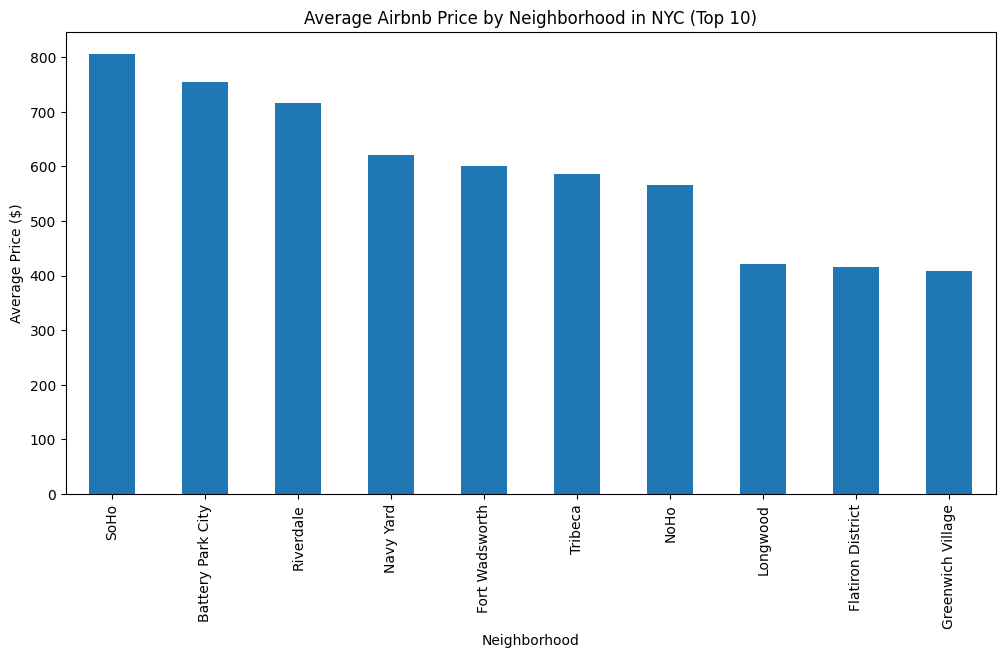

In [17]:
import matplotlib.pyplot as plt

# Plot average price by neighborhood (top 10)
avg_price_by_neighborhood.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Average Airbnb Price by Neighborhood in NYC (Top 10)')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.show()

#### Seasonal Availability
A line plot shows availability trends over months.

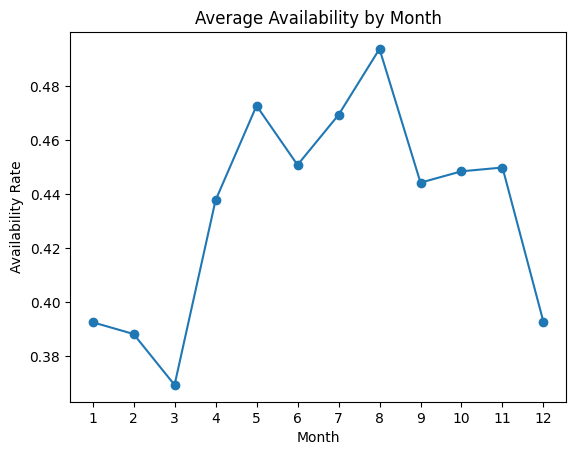

In [18]:
# Plot availability by month
availability_by_month.plot(kind='line', marker='o')
plt.title('Average Availability by Month')
plt.xlabel('Month')
plt.ylabel('Availability Rate')
plt.xticks(range(1, 13))
plt.show()

#### Price vs. Reviews by Price Bin
A bar chart illustrates how occupancy (via reviews) varies with price.

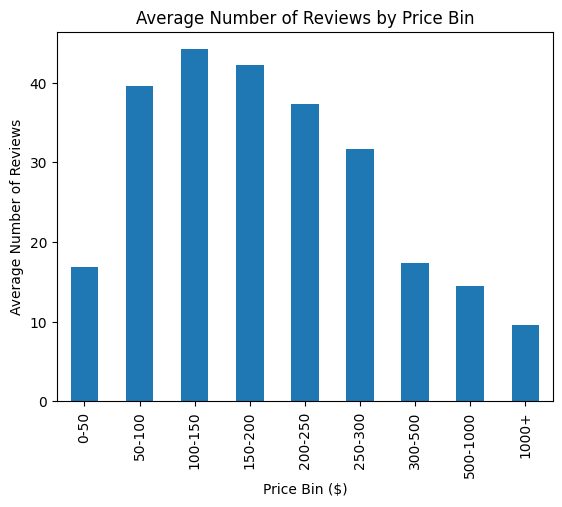

In [19]:
# Plot reviews by price bin
avg_reviews_by_price.plot(kind='bar')
plt.title('Average Number of Reviews by Price Bin')
plt.xlabel('Price Bin ($)')
plt.ylabel('Average Number of Reviews')
plt.show()

#### Interactive Map
Using Folium, we create a map of listings colored by price.

In [21]:
import folium

# Create a map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add markers
for index, row in listings.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red' if row['price'] > 200 else 'blue',
        fill=True,
        fill_color='red' if row['price'] > 200 else 'blue',
        fill_opacity=0.6,
        popup=f"Price: ${row['price']}"
    ).add_to(nyc_map)

# Save the map
nyc_map.save('nyc_airbnb_map.html')

### 8. Summary of Findings
* **Price Variation by Neighborhood:** The top 5 most expensive neighborhoods are [e.g., Tribeca, SoHo], with averages exceeding $300/night, while affordable areas include [e.g., Bronx neighborhoods].

* **Peak Booking Periods:** Months with the lowest availability (e.g., summer months like June-August) suggest peak demand.

* **Amenities and Pricing:** Amenities like hot tubs or premium Wi-Fi correlate strongly with higher prices.

* **Popular Property Types:** Apartments dominate, with entire homes and private rooms being the most common room types.

* **Occupancy Trends:** Listings in the $100-150 range have the highest average reviews, indicating a popular price point.

### 9. Recommendations
**For Hosts**
* Add high-value amenities (e.g., hot tubs) to justify higher prices.
* Increase rates during peak months (e.g., June-August) when availability is low.

**For Travelers**
* Book in affordable neighborhoods like [e.g., Bronx areas] for lower prices.
* Travel during off-peak months (e.g., winter months) for better deals.

**For City Planners**
* Monitor neighborhoods with high entire-home listings (e.g., Manhattan areas), as they may impact long-term housing availability.
* Note that these trends reflect data influenced by NYC’s short-term rental regulations.